# Maximum Likelihood Estimation

Authors: Audrey Olivier, Dimitris G. Giovanis <br>
Last modified on 12/14/2018 by Audrey Olivier

This notebook illustrates the use of the Model class to create a model for inference, and the MLEstimation class to perform maximum likelihood estimation of the parameters of that model. Recall that a maximum likelihood estimate is simply the parameter vector that maximizes the likelihood:

$$ \theta_{ML} = argmax_{\Theta} \left[ p(data \vert \theta) \right] $$

In particular, the following models are studied:
- a probability model with an existing fit method,
- a probability model without a fit method (custom distribution, or distribution with copulas),
- a python model defined with RunModel.

## Probability distribution model with an existing fit method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import Model, MLEstimation
from UQpy.Distributions import Distribution

Shape of data vector: (1000,)


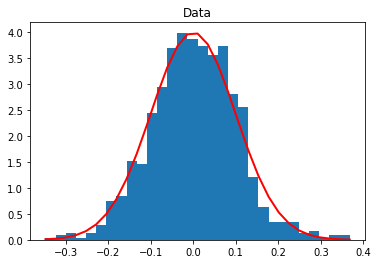

In [2]:
mu, sigma = 0, 0.1 # true mean and standard deviation
data_1 = np.random.normal(mu, sigma, 1000)
print('Shape of data vector: {}'.format(data_1.shape))

count, bins, ignored = plt.hist(data_1, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('Data')
plt.show()

Create an instance of the class Model. The user must define the number of parameters to be estimated, in this case 2 (mean and standard deviation). For maximum likelihood estimation, no prior pdf is required.

In [3]:
candidate_model = Model(model_type = 'pdf', n_params = 2, model_name = 'normal')

Perform maximum likelihood. Setting verbose=True, some comments are written and one can see that the maximul likelihood procedure uses the fit method of the probability distribution.

In [4]:
ml_estimator = MLEstimation(model=candidate_model, data=data_1, verbose=True)
print('ML estimates of the mean={0:.3f} (true=0.) and std. dev={1:.3f} (true=0.1)'.format(ml_estimator.param[0], ml_estimator.param[1]))

Evaluating max likelihood estimate for model normal using its fit method.
Max likelihood estimation completed.
ML estimates of the mean=0.003 (true=0.) and std. dev=0.101 (true=0.1)


## Probability model for which the fit method is not defined.

Here we define a bivariate probability model, with a dependence structure defined using a gumbel copula. The goal of inference is to learn the paremeters of the Gaussian marginals and the copula parameter, i.e., the model has 5 unknown parameters. 

First data is generated from a true model. A distribution with copulas does not possess a fit method, thus sampling is performed using importance sampling/resampling.

Shape of data: (5000, 2)


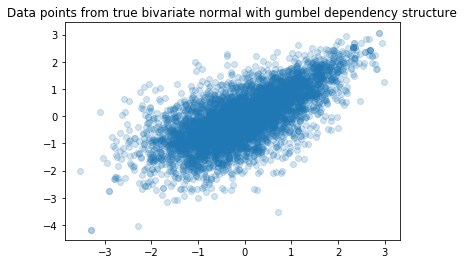

In [5]:
# dist_true exhibits dependence between the two dimensions, defined using a gumbel copula
dist_true = Distribution(dist_name=['normal', 'normal'], copula='gumbel')
params_dist = [[0, 1], [0, 1]]
params_copula = 2

# generate data using importance sampling: sample from a bivariate gaussian without copula, then weight samples
from UQpy.SampleMethods import IS
u = IS(pdf_proposal=['normal']*2, pdf_proposal_params=[[0, 1], [0, 1]],
       pdf_target=['normal', 'normal'], pdf_target_copula='gumbel', pdf_target_params=[[0, 1], [0, 1]], 
       pdf_target_copula_params = [2], 
       nsamples=500000)
# Resample to obtain 5,000 data points
data_2 = u.resample(size=5000)
print('Shape of data: {}'.format(data_2.shape))

fig, ax = plt.subplots()
ax.scatter(data_2[:,0], data_2[:,1], alpha=0.2)
ax.set_title('Data points from true bivariate normal with gumbel dependency structure')
plt.show()

To define a model for inference, the user must create a custom file, here bivariate_normal_gumbel.py, to compute the log_pdf of the distribution, given a bivariate data matrix and a parameter vector of length 5. Note that for any probability model that is not one of the simple univariate pdfs supported by UQpy, such a custom file will be necessary.

In [6]:
candidate_model = Model(model_type = 'pdf', n_params = 5, model_name = 'bivariate_normal_gumbel')

When calling MLEstimation for a distribution model without a fit, or a python model, the function minimize from the scipy.optimize package is used. The user can define bounds for the optimization, a seed, the algorithm to be used, and set the algorithm to perform several optimization iterations, starting at a different random seed every time.

In [7]:
ml_estimator = MLEstimation(model=candidate_model, data=data_2, verbose=True,
                            bounds = [[-5, 5], [0, 10], [-5, 5], [0, 10], [1.01, 4]], iter_optim=1,
                            method_optim='SLSQP')

print('ML estimates of the mean={0:.3f} and std. dev={1:.3f} of 1st marginal (true: 0.0, 1.0)'.
      format(ml_estimator.param[0], ml_estimator.param[1]))
print('ML estimates of the mean={0:.3f} and std. dev={1:.3f} of 2nd marginal (true: 0.0, 1.0)'.
      format(ml_estimator.param[2], ml_estimator.param[3]))
print('ML estimates of the copula parameter={0:.3f} (true: 2.0)'.format(ml_estimator.param[4]))

Evaluating max likelihood estimate for model bivariate_normal_gumbel using its fit method.
Evaluating max likelihood estimate for model bivariate_normal_gumbel using optimization.
Evaluating max likelihood estimate for model bivariate_normal_gumbel using optimization procedure.
Max likelihood estimation completed.
ML estimates of the mean=-0.040 and std. dev=0.992 of 1st marginal (true: 0.0, 1.0)
ML estimates of the mean=-0.055 and std. dev=1.001 of 2nd marginal (true: 0.0, 1.0)
ML estimates of the copula parameter=1.948 (true: 2.0)


## Regression model (model linear in the parameters)

Here a model is defined that is of the form 

$$y=f(\theta) + \epsilon$$

where f consists in running RunModel. In particular, here $f(\theta)=\theta_{0} x + \theta_{1} x^{2}$ is a regression model.

First we generate synthetic data, and add some noise to it.

In [8]:
# Generate data
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape((1, -1))
error_covariance = np.eye(50)

print(param_true.shape)
from UQpy.RunModel import RunModel
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_0', 'theta_1'])
data_3 = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data_3)

(1, 2)
[  0.444701     1.0203273   -0.31672864   0.94538848   1.62210507
   2.78049948   2.90515982   4.77121518   7.10144138   9.8973993
  10.23674263  12.64378402  14.08334244  15.25796751  20.43326853
  21.37071267  24.45224898  26.12444488  30.51083727  33.39053854
  37.40454816  39.39199287  44.6518242   51.1311061   54.49242676
  58.2329205   62.9933784   65.7436655   71.86667581  77.50668006
  82.29284347  87.01500651  92.51254863  97.95513239 103.73958245
 109.42849684 114.43422234 120.40312872 129.63026314 135.03819647
 141.37296155 148.39254883 156.16333947 161.49794838 172.12540987
 176.19842151 183.56974808 193.45271414 199.86140884 210.06365344]


Then we create an instance of the Model class, using model_type='python', and we perform maximum likelihood estimation of the two parameters.

In [9]:
candidate_model = Model(n_params=2, model_type='python', 
                        model_script='pfn_models.py', model_object_name = 'model_quadratic', 
                        error_covariance=error_covariance, var_names = ['theta_0', 'theta_1'])

In [10]:
ml_estimator = MLEstimation(model=candidate_model, data=data_3)
print('fitted parameters: theta_0={0:.3f} (true=1.), and theta_1={1:.3f} (true=2.)'.format(ml_estimator.param[0],
                                                                                ml_estimator.param[1]))

fitted parameters: theta_0=1.157 (true=1.), and theta_1=1.980 (true=2.)
